In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import glob
from scipy.stats.kde import gaussian_kde
from numpy import linspace
import time
from scipy import interpolate
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

from ipywidgets import IntProgress
from IPython.display import display

sns.set()

In [2]:
from natal_kick_tools import mandel_muller_likelihood_functions as mmf
from natal_kick_tools import likelihood_plot_functions as lpf

In [3]:
# this is just a little function that we will use to make the plot more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [4]:
# Define the models of interest
bh_kicks=[200]
ns_kicks = [300, 350, 400, 450, 500, 550, 600, 650, 700]
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5]

# Define the location of the posterior data
pulsar_data_loc = "../correctedPulsarPosteriors/correctedVtData"

# Read Velocity Data

## Model Velocities

In [5]:
# Define a dictionary to map v_ns and sigma to their arrays
kick_models = {}
sig = len(sigmas)
vns = len(ns_kicks)

for i in range(len(ns_kicks)):
    kick_models[f"NS_{ns_kicks[i]}_RANGE"] = np.arange(i*sig, (i*sig)+sig, 1)

for i in range(len(sigmas)):
    kick_models[f"SIGMA_{sigmas[i]}_RANGE"] = np.arange(i, (vns*sig) + i, sig)

kick_models["ALL"] = np.arange(0, vns*sig, 1)

In [6]:
# Read model velocity data (takes ~2 min)

start = time.time()

NS_KICKS_3D = []
NS_KICKS_2D = []
NS_KICK_MULT = [] 
SIGMAS = []

f = IntProgress(min=0, max=sig*vns) # instantiate the bar
display(f) # display the bar

for ns_kick in ns_kicks:
    for sigma in sigmas:
        f.value +=1
        fname = f"model_velocities/vns_{ns_kick}_sigma_{sigma}_velocities"
        v_3d, v_2d = np.loadtxt(fname, skiprows=1, unpack=True)
        NS_KICKS_3D.append(v_3d)
        NS_KICKS_2D.append(v_2d)
        NS_KICK_MULT.append(ns_kick)
        SIGMAS.append(sigma)    
        
end = time.time()
print(end - start, "s")

IntProgress(value=0, max=45)

89.43927907943726 s


In [7]:
def plot_kde(PLOT_RANGE, d=2):
 
    for i in PLOT_RANGE:
        kde_NS_3D = gaussian_kde( NS_KICKS_3D[i] )
        kde_NS_2D = gaussian_kde( NS_KICKS_2D[i] )
        NS_dist_space = linspace( min(NS_KICKS_3D[i]), max(NS_KICKS_3D[i]), 100 )
        
        if d==2:
            plt.plot( NS_dist_space, kde_NS_2D(NS_dist_space), label=f'2D Projected Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');
        else:
            plt.plot( NS_dist_space, kde_NS_3D(NS_dist_space), label=f'3D Model Kicks (v_ns={NS_KICK_MULT[i]}, sigma={SIGMAS[i]})');

    layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
               nameY='Kick Velocity prob dist [km/s ^-1]')

    plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

    # plt.ylim(0, 5e-3)
    plt.xlim(0, 1200)

    plt.legend(fontsize=17)

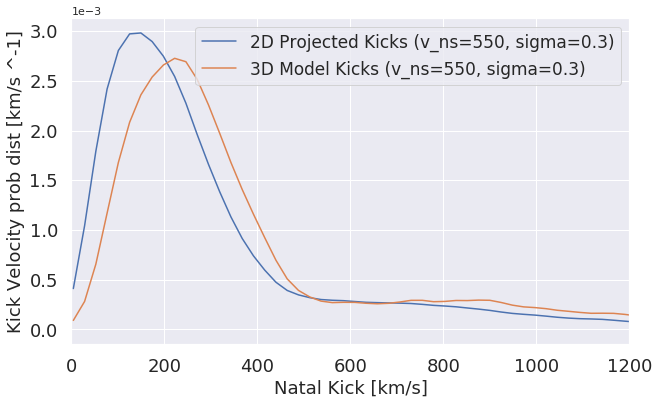

In [8]:
f, ax= plt.subplots(1, 1,  figsize=(10,6)) 
plot_kde(np.intersect1d(kick_models["NS_550_RANGE"], kick_models["SIGMA_0.3_RANGE"]), d=2)
plot_kde(np.intersect1d(kick_models["NS_550_RANGE"], kick_models["SIGMA_0.3_RANGE"]), d=3)
plt.show()

# Read Likelihood Data

In [9]:
p_models = []
columns = [] # labels for plotting model likelihoods in next cell
for ns_kick in ns_kicks:
    for sigma in sigmas:
        fname = f"calculatedModelLikelihoods/vns_{ns_kick}_sigma_{sigma}"
        all_likelihoods = np.loadtxt(fname)
        p_models.append(np.prod(all_likelihoods))
        
        col_name = f"vns_{ns_kick}_sigma_{sigma}"
        columns.append(col_name)
        
# normalize the array
p_models = p_models/np.sum(p_models)

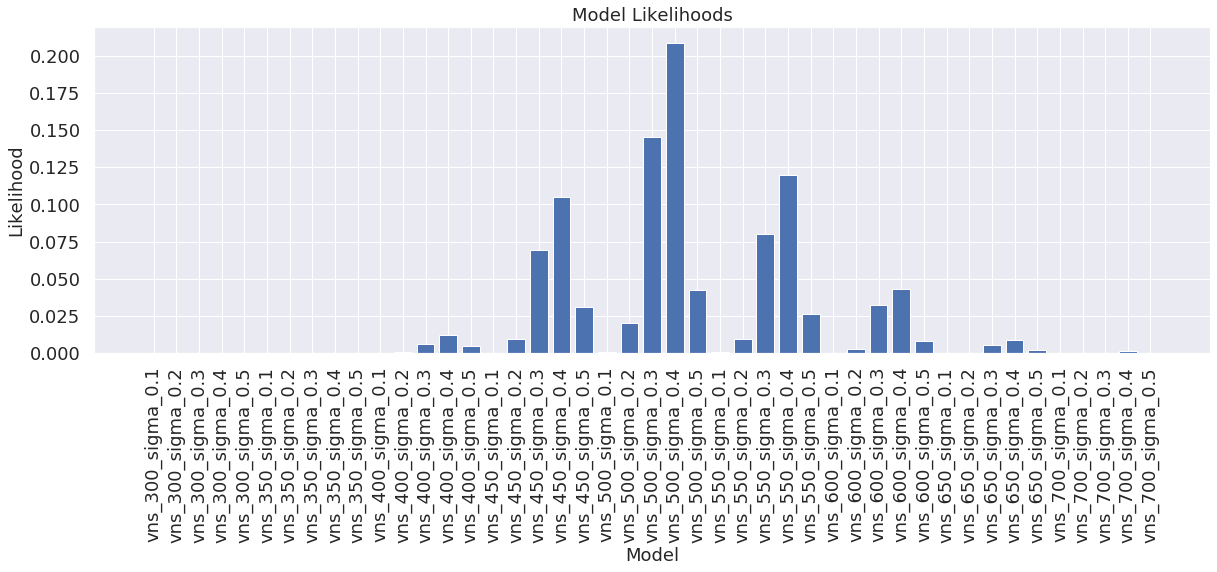

In [10]:
f, ax= plt.subplots(1, 1,  figsize=(20,6)) 

x_range = np.linspace(0, len(p_models), len(p_models))
plt.bar(x_range, p_models, tick_label=columns)

layoutAxes(ax=ax, nameX='Model',\
           nameY='Likelihood')
plt.xticks(rotation=90)
# plt.semilogy()

plt.title("Model Likelihoods", fontsize=18)

plt.show()

## 2D Plot

In [11]:
p_models_2d = p_models.reshape([len(ns_kicks), len(sigmas)])
max_num = len(p_models) # number of max likelihoods to label

# Some code to generate labels for only the top n models
M = sorted(zip(p_models), reverse=True)[max_num - 1][0]
label_f  = np.vectorize(lambda v: f"{v:.3f}" if v >= M else '')
labels = label_f(p_models_2d)

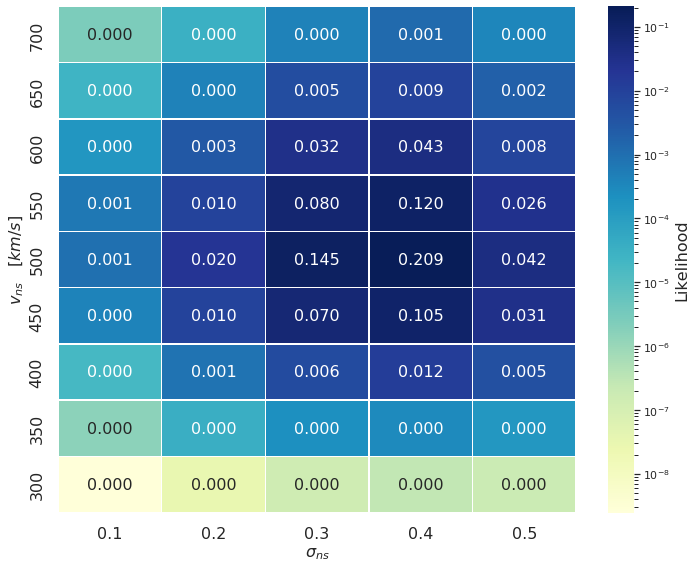

In [12]:
f, ax= plt.subplots(1, 1,  figsize=(10,8)) 

ax = sns.heatmap(p_models_2d, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), xticklabels=sigmas, yticklabels=ns_kicks, \
                annot=labels, annot_kws={'fontsize':16}, fmt='', cbar_kws={'label': 'Likelihood'})
layoutAxes(ax=ax, nameX='$\sigma_{ns}$',\
           nameY='$v_{ns} \quad [km/s]$', fontsize = 16)

ax.figure.axes[-1].yaxis.label.set_size(16)

plt.gca().invert_yaxis()
plt.tight_layout()
# plt.savefig('plots/model_likelihoods_2d.pdf')  
plt.show()


In [13]:
# Identify the 3 most likely models
M = sorted(zip(p_models), reverse=True)[:3]
MAX_INDICES = np.where(p_models==M)[1]

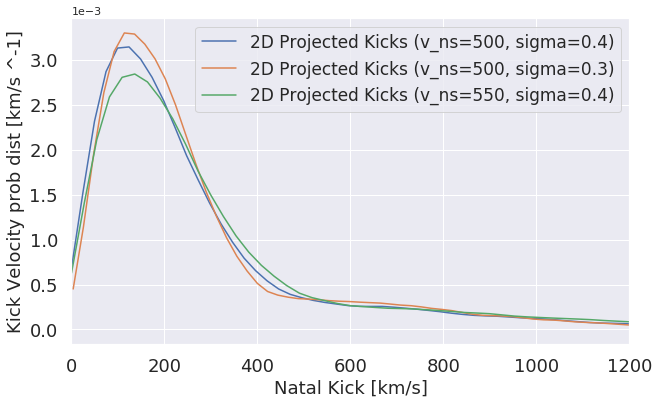

In [14]:
# The three most likely models
f, ax= plt.subplots(1, 1,  figsize=(10,6))
plot_kde(MAX_INDICES, d=2)
plt.show()

# Load Posterior Data

In [15]:
# Takes about 30 s
start = time.time()

vt_all = []

f = IntProgress(min=0, max=len(glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'))) # instantiate the bar
display(f) # display the bar

for file in glob.glob('../correctedPulsarPosteriors/correctedVtData/*.bootstraps'):
    f.value +=1
    vt_all.append(np.loadtxt(file, unpack=True, usecols=5))

end = time.time()
print(end - start, "s")

IntProgress(value=0, max=89)

27.66474437713623 s


In [16]:
PLOT_DATA = [vt_all, NS_KICKS_2D, NS_KICK_MULT, SIGMAS] # Needed to make all the cdf functions work

# PDF and CDF Plots

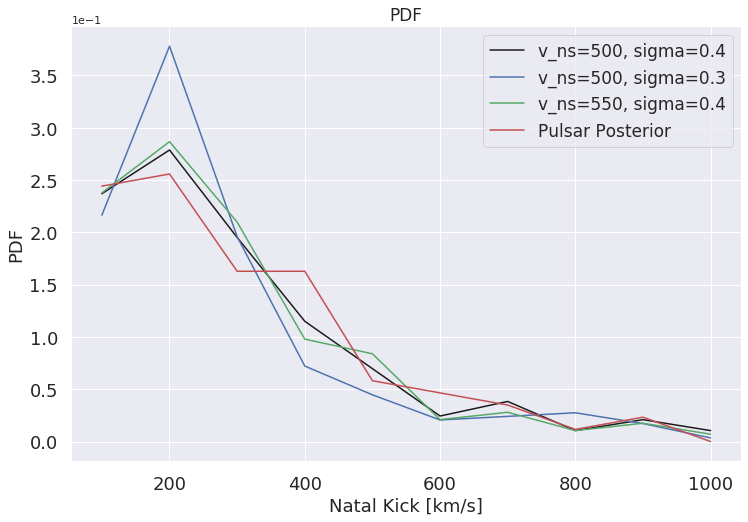

In [17]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[0], color='k')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[1], color='C0')
lpf.plot_model_pdf(*PLOT_DATA, MAX_INDICES[2], color='g')

lpf.plot_posterior_pdf(*PLOT_DATA, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='PDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"PDF", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
# plt.semilogx()
plt.show()


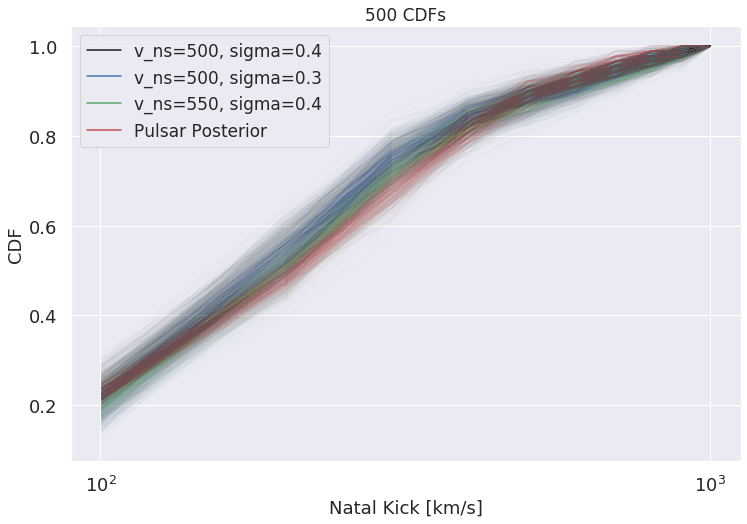

Plot completed in 25.747396 s


In [18]:
n_cdf = 500
n_draws = 200
alpha = 5/n_cdf

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

start = time.time()

lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_draws=n_draws, color='k', alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_draws=n_draws, color='C0', alpha=alpha)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_draws=n_draws, color='g', alpha=alpha)

# Posterior CDF always contains len(vt_all) data points in current implementation. 
# See 'draw_posterior_cdf' function for alternate implementation with n_draws data points
lpf.plot_posterior_cdf(*PLOT_DATA, n_cdf, n_draws=n_draws, color='r', alpha=alpha)



layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='CDF')

plt.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

plt.title(f"{n_cdf} CDFs", fontsize=17)

leg = plt.legend(fontsize=17)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    
    
plt.semilogx()
plt.show()

end = time.time()
print(f"Plot completed in {end - start:2f} s")

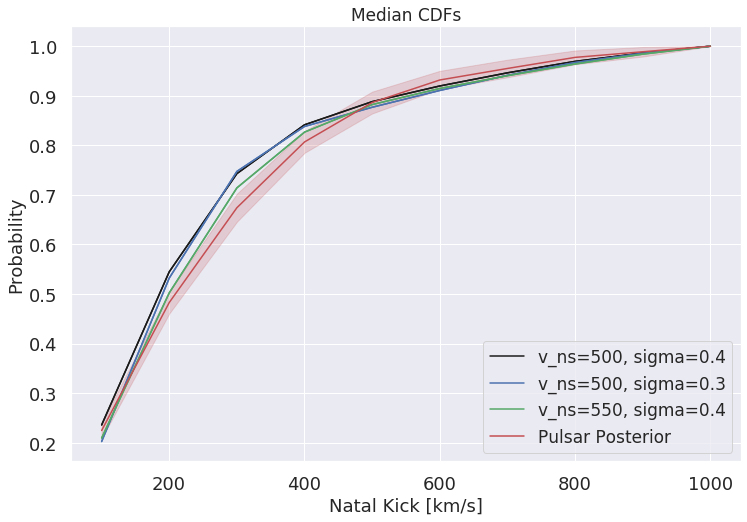

Plot completed in 4.176949 s


In [45]:
sns.set()
n_bins = 10

n_cdf = 1
n_cdf_posterior = 100

n_draws = 500000
posterior_draws = 89

start = time.time()


f, ax= plt.subplots(1, 1,  figsize=(12,8)) 


lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_draws=n_draws, color='k', alpha=1)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_draws=n_draws, color='C0', alpha=1)
lpf.plot_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_draws=n_draws, color='g', alpha=1)


lpf.plot_avg_posterior_cdf(*PLOT_DATA, n_cdf_posterior, n_bins=n_bins, n_draws=posterior_draws, color='r')


layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
           nameY='Probability')


plt.title(f"Median CDFs", fontsize=17)

plt.legend(fontsize=17)
    
    
# plt.semilogx()

plt.savefig('plots/model_cdfs.pdf')
plt.show()


end = time.time()
print(f"Plot completed in {end - start:2f} s")

## See effect of changing n_cdf, n_draws

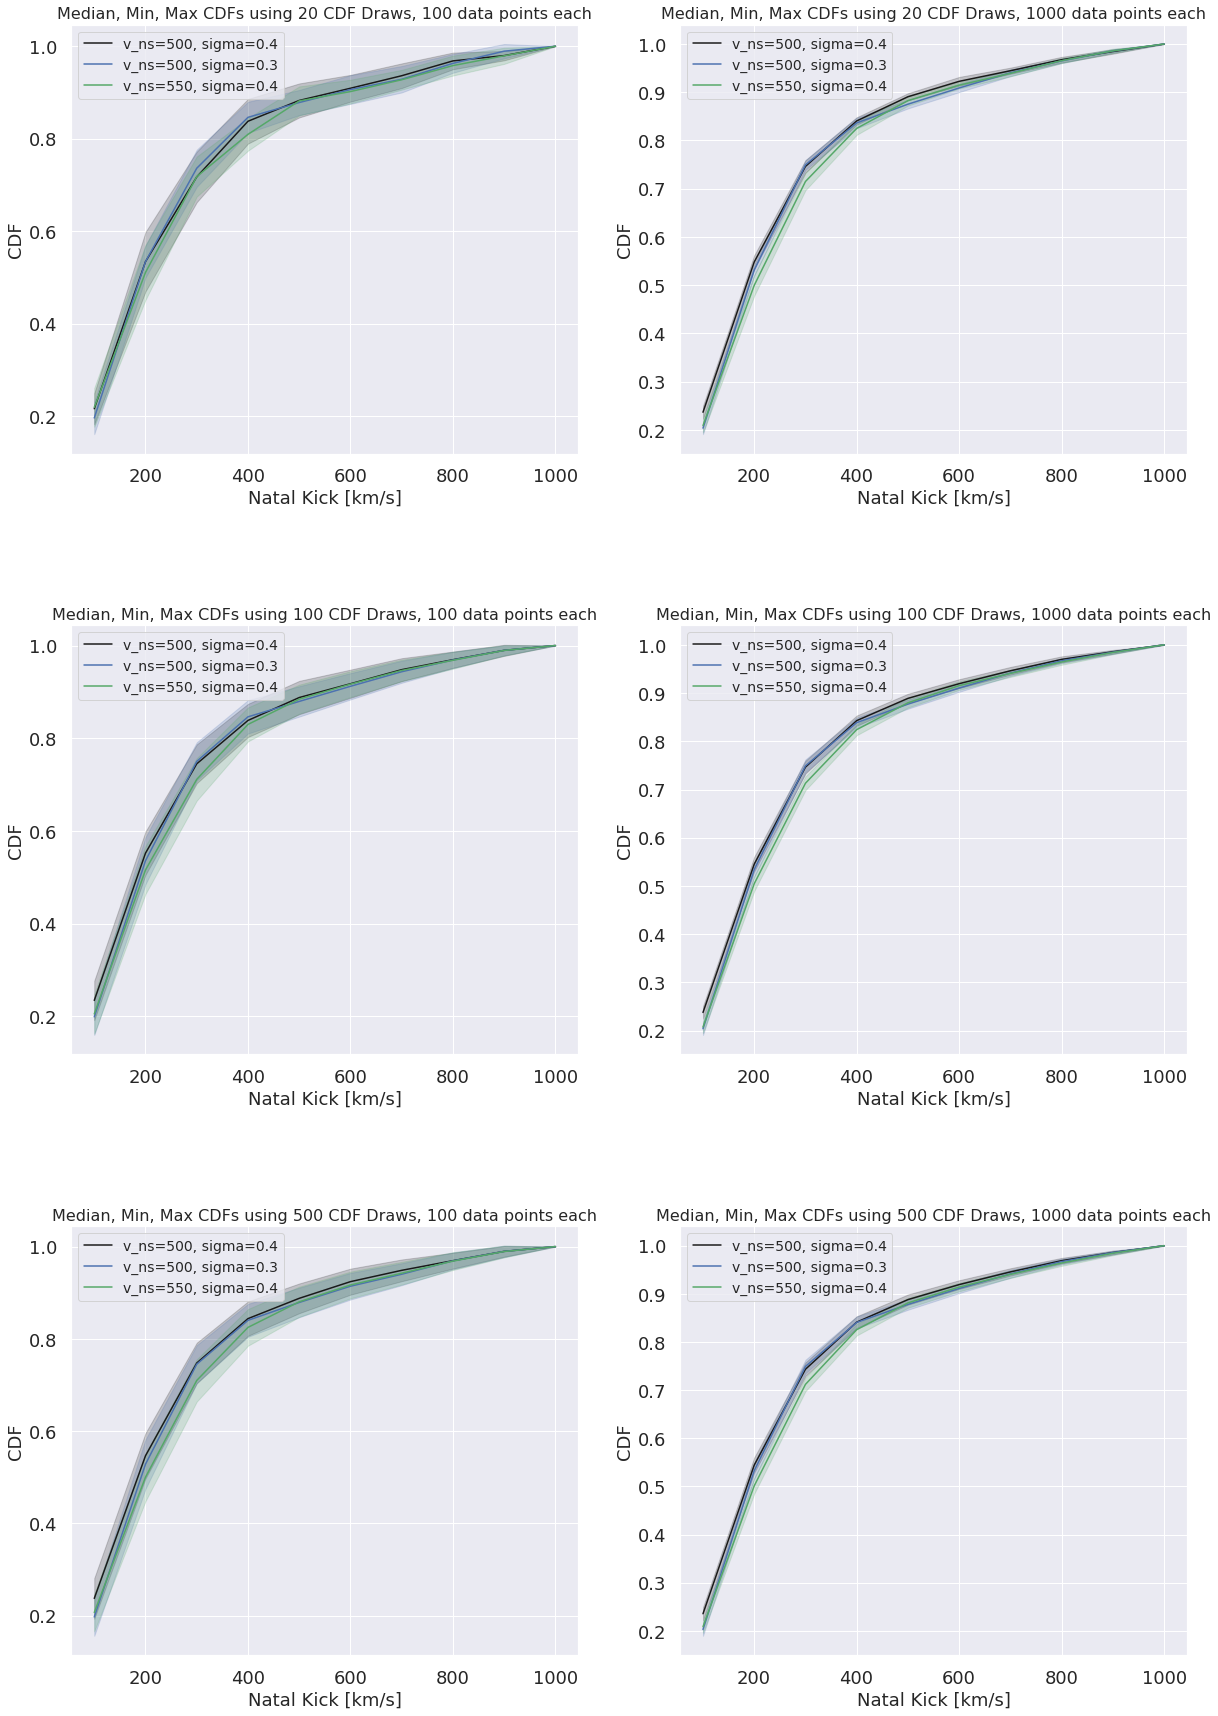

Plot completed in 41.382532 s


In [20]:
# Takes ~40 seconds
n_cdfs = [20, 100, 500]
n_bins = 10
n_drawss = [100, 1000]

start = time.time()

plt.figure(figsize=(20, 30))
plt.subplots_adjust(hspace=0.4)
n=1

for n_cdf in n_cdfs:
    for n_draws in n_drawss:
        ax = plt.subplot(3, 2, n)
        n+=1
        lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws, color='k')
        lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws, color='C0')
        lpf.plot_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws, color='g')

        layoutAxes(ax=ax, nameX='Natal Kick [km/s]',\
                   nameY='CDF')

        plt.title(f"Median, Min, Max CDFs using {n_cdf} CDF Draws, {n_draws} data points each", fontsize=16)
        plt.legend(fontsize=14)

plt.show()


end = time.time()
print(f"Plot completed in {end - start:2f} s")

As expected, we see the following two trends:
1. Increasing the number of CDFs drawn (n_cdfs) doesn't affect the std err, since we capture the spread of each cdf bin well enough at low n_cdf.

2. Increasing the number of data draws per CDF (n_draws) reduces the variation between CDFs, resulting in a smaller spread. At the limit of n_draws = all data points in simulation, the variation will be zero.

Visually, the Green curve (vns=550, sigma=0.4) has the closest CDF and PDF to the posterior, even though it is the 3rd most likely model from Bayesian Analysis. Let's confirm this using a KS test...

# K-S Test

In [21]:
# Get all the cdfs needed for KS test
n_cdf = 1
n_bins = 30
n_draws = 10000
bins, cdf_0, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws)
bins, cdf_1, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws)
bins, cdf_2, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws)

bins_posterior, cdf_posterior, cdf_min, cdf_max, draws = lpf.get_avg_posterior_cdf(*PLOT_DATA, n_cdf, n_bins=n_bins)

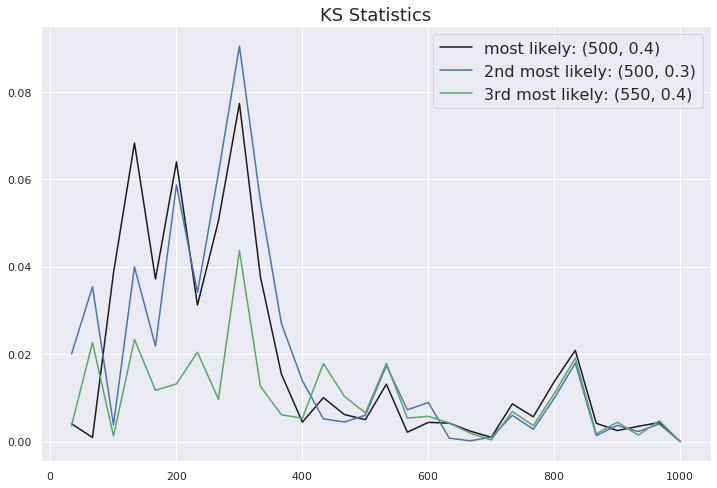

In [22]:
# Plot the KS-statistics

f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
plt.plot(bins, np.abs(cdf_0 - cdf_posterior), color='k', label=f'most likely: ({NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]})')
plt.plot(bins, np.abs(cdf_1 - cdf_posterior), color='C0', label=f'2nd most likely: ({NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]})')
plt.plot(bins, np.abs(cdf_2 - cdf_posterior), color='g', label=f'3rd most likely: ({NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]})')
plt.title("KS Statistics", fontsize=18)

plt.legend(fontsize=16)
plt.show()

In [23]:
print(f"KS Statistic for {NS_KICK_MULT[MAX_INDICES[0]]}, {SIGMAS[MAX_INDICES[0]]} =", np.max(np.abs(cdf_0 - cdf_posterior)))
print(f"KS Statistic for {NS_KICK_MULT[MAX_INDICES[1]]}, {SIGMAS[MAX_INDICES[1]]} =", np.max(np.abs(cdf_1 - cdf_posterior)))
print(f"KS Statistic for {NS_KICK_MULT[MAX_INDICES[2]]}, {SIGMAS[MAX_INDICES[2]]} =", np.max(np.abs(cdf_2 - cdf_posterior)))

KS Statistic for 500, 0.4 = 0.07733302041665158
KS Statistic for 500, 0.3 = 0.09042709594667497
KS Statistic for 550, 0.4 = 0.04365981232458582


## My KS Implementation with Errors

In [28]:
N_TESTS = 500

ks_stats_me = [np.zeros(N_TESTS), np.zeros(N_TESTS), np.zeros(N_TESTS)]
# p_values_me = [np.zeros(N_TESTS), np.zeros(N_TESTS), np.zeros(N_TESTS)]

In [29]:
start = time.time()

n_cdf = 1
n_bins = 20
n_draws = 100000
bins, cdf_0, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[0], n_bins=n_bins, n_draws=n_draws)
bins, cdf_1, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[1], n_bins=n_bins, n_draws=n_draws)
bins, cdf_2, cdf_min, cdf_max, draws  = lpf.get_avg_model_cdf(*PLOT_DATA, n_cdf, MAX_INDICES[2], n_bins=n_bins, n_draws=n_draws)

end = time.time()
print(f"Average CDFs from {n_cdf} draws computed in {end - start:2f} s")

Average CDFs from 1 draws computed in 0.852308 s


In [30]:
model_cdfs = [cdf_0, cdf_1, cdf_2]

In [31]:
print("Performing KS-Test")
start = time.time()
f = IntProgress(min=0, max=N_TESTS) # instantiate the bar
display(f) # display the bar

for n_test in range(N_TESTS):
    f.value += 1 
    for i in range(3):
        # Draw posterior sample
        vt_draw, bins, posterior_cdf, posterior_pdf = lpf.draw_posterior_cdf(vt_all, n_bins=n_bins)
    
        ks_stats_me[i][n_test] = np.max(np.abs(model_cdfs[i] - posterior_cdf))

end = time.time()
print(f"KS-Test completed in {end - start:2f} s")

Performing KS-Test


IntProgress(value=0, max=500)

KS-Test completed in 14.177308 s


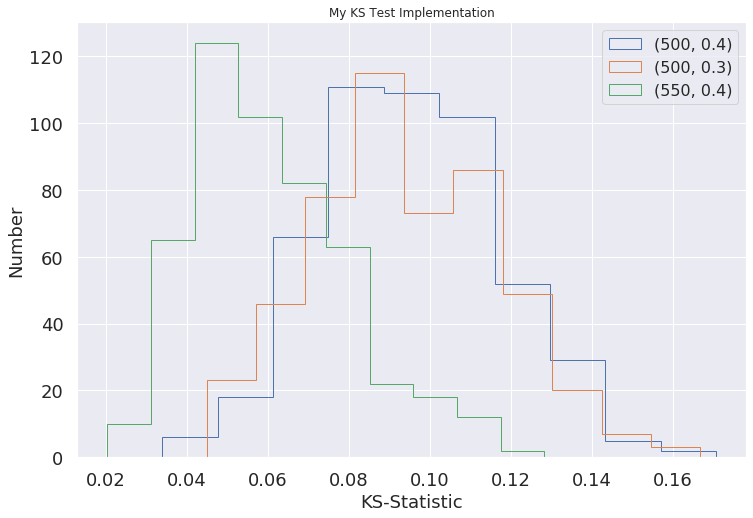

In [32]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
for i in range(3):
    plt.hist(ks_stats_me[i], histtype='step', label=f'({NS_KICK_MULT[MAX_INDICES[i]]}, {SIGMAS[MAX_INDICES[i]]})')

plt.title("My KS Test Implementation")
layoutAxes(ax=ax, nameX='KS-Statistic',\
                   nameY='Number')
plt.legend(fontsize=16)
plt.show()

In [33]:
for i in range(3):
    print(f"KS Test for {NS_KICK_MULT[MAX_INDICES[i]]}, {SIGMAS[MAX_INDICES[i]]}:",\
          f" ks_stat = {np.mean(ks_stats_me[i]):.3f} +/- {np.std(ks_stats_me[i]):.3f}")
    

KS Test for 500, 0.4:  ks_stat = 0.095 +/- 0.022
KS Test for 500, 0.3:  ks_stat = 0.095 +/- 0.023
KS Test for 550, 0.4:  ks_stat = 0.061 +/- 0.020


## Scipy implementation

In [34]:
vt_all_flat = [item for sublist in vt_all for item in sublist] # in case I should use ALL the posteriors

In [35]:
from scipy.stats import *

In [36]:
n_draws = 100000

In [37]:
vt_draw = np.zeros(len(vt_all))        
for i in range(len(vt_draw)):
    vt_draw[i] = vt_all[i][np.random.randint(len(vt_all[i]))]

In [38]:
# f, ax= plt.subplots(1, 1,  figsize=(12,8)) 

for i in [0,1,2]:
    model = NS_KICKS_2D[MAX_INDICES[i]]
    model_draws = np.zeros(n_draws)
    bins = lpf.set_bins_from_posterior(vt_draw, n_bins=n_bins) 
    for j in range(len(model_draws)):
        model_draws[j] = model[np.random.randint(len(model))]
    
    ks_stat, p_value = ks_2samp(vt_draw, model_draws)
#     ks_stat, p_value = ks_2samp(vt_all_flat, model_draws)

    print(f"KS Test for {NS_KICK_MULT[MAX_INDICES[i]]}, {SIGMAS[MAX_INDICES[i]]}: ks_stat = {ks_stat}, p_value = {p_value}")
    
#     plt.hist(model_draws, bins=bins, histtype='step', density=True, label=f'({NS_KICK_MULT[MAX_INDICES[i]]}, {SIGMAS[MAX_INDICES[i]]})')

# plt.hist(vt_draw, bins=bins, histtype='step', density=True, label='posterior', color='r')
# plt.legend(fontsize=16)
# plt.show()

KS Test for 500, 0.4: ks_stat = 0.1000262921348315, p_value = 0.33587324543810354
KS Test for 500, 0.3: ks_stat = 0.10901629213483155, p_value = 0.2411860732788532
KS Test for 550, 0.4: ks_stat = 0.06971213483146066, p_value = 0.7805089219782232


I'm not convinced I'm correctly using the KS test from scipy, but the general result remains the same: the (550, 0.4) model is the closest match to the posterior.

(Could this be an artifact of the way I sample CDFs? Although this shouldn't be an issue for the scipy implementation because that takes in ALL the data and posteriors)

## Scipy KS Test with Errors

In [39]:
N_TESTS = 500

ks_stats = [np.zeros(N_TESTS), np.zeros(N_TESTS), np.zeros(N_TESTS)]
p_values = [np.zeros(N_TESTS), np.zeros(N_TESTS), np.zeros(N_TESTS)]

In [40]:
model_data = [NS_KICKS_2D[MAX_INDICES[0]], NS_KICKS_2D[MAX_INDICES[1]], NS_KICKS_2D[MAX_INDICES[2]]]

In [42]:
print("Performing KS-Test")
start = time.time()
f = IntProgress(min=0, max=N_TESTS) # instantiate the bar
display(f) # display the bar

for n_test in range(N_TESTS):
    f.value +=1
    for i in range(3):
        # Draw posterior sample
        vt_draw = np.zeros(len(vt_all))        
        for j in range(len(vt_draw)):
            vt_draw[j] = vt_all[j][np.random.randint(len(vt_all[j]))]
            
        ks_stats[i][n_test], p_values[i][n_test] = ks_2samp(vt_draw, model_data[i])
end = time.time()
print(f"KS-Test completed in {end - start:2f} s")

Performing KS-Test


IntProgress(value=0, max=500)

KS-Test completed in 55.048387 s


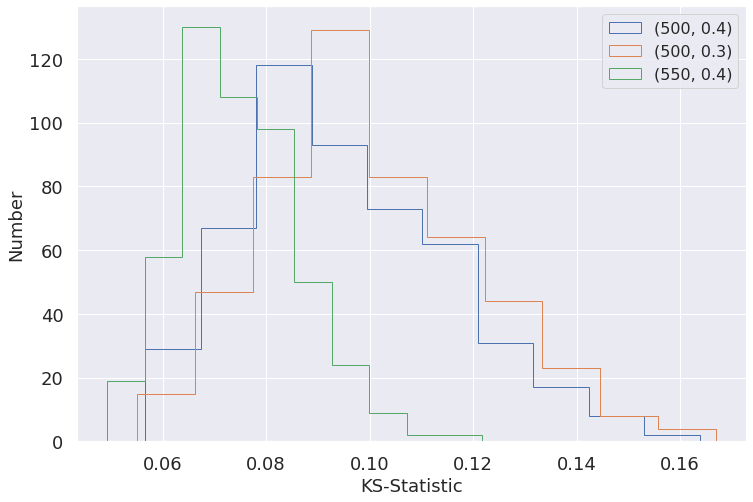

In [43]:
f, ax= plt.subplots(1, 1,  figsize=(12,8)) 
for i in range(3):
    plt.hist(ks_stats[i], histtype='step', label=f'({NS_KICK_MULT[MAX_INDICES[i]]}, {SIGMAS[MAX_INDICES[i]]})')

layoutAxes(ax=ax, nameX='KS-Statistic',\
                   nameY='Number')
plt.legend(fontsize=16)
plt.show()

In [44]:
for i in range(3):
    print(f"KS Test for {NS_KICK_MULT[MAX_INDICES[i]]}, {SIGMAS[MAX_INDICES[i]]}:",\
          f" ks_stat = {np.mean(ks_stats[i]):.3f} +/- {np.std(ks_stats[i]):.3f}, ", \
          f"p_value = {np.mean(p_values[i]):.3f}+/-{np.std(p_values[i]):.3f}")
    

KS Test for 500, 0.4:  ks_stat = 0.096 +/- 0.020,  p_value = 0.434+/-0.228
KS Test for 500, 0.3:  ks_stat = 0.100 +/- 0.020,  p_value = 0.381+/-0.217
KS Test for 550, 0.4:  ks_stat = 0.075 +/- 0.012,  p_value = 0.692+/-0.166
